Learning to use pytorch. Based on the tutorial from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Uncomment this to use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

# Uncomment this to use CPU
# device = 'cpu'

cuda:0


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

# Code to implement both a training dataset and a validation dataset
train_size = int(0.9 * len(trainvalset))

# # Define the indices for each split
train_indices = range(0, train_size)
val_indices = range(train_size, len(trainvalset))

# # Create subsets
train_dataset = Subset(trainvalset, train_indices)
val_dataset = Subset(trainvalset, val_indices)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True,  num_workers = 2)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False,  num_workers = 2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 12870340.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([100, 3, 32, 32])


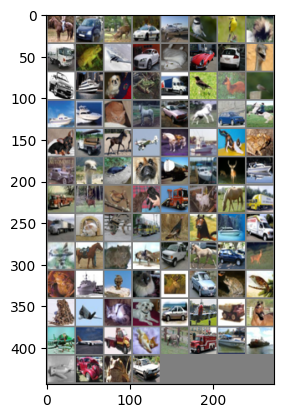

horse car   deer  car   plane bird  bird  dog   truck frog  plane car   cat   car   car   bird  car   ship  dog   frog  truck bird  deer  bird  ship  ship  cat   horse car   horse car   horse dog   truck horse plane horse ship  cat   frog  car   bird  bird  dog   truck ship  deer  ship  truck deer  bird  dog   truck cat   horse truck truck cat   horse truck bird  horse ship  truck plane horse cat   plane car   horse car   deer  frog  ship  bird  cat   deer  car   frog  bird  frog  plane cat   dog   car   plane truck horse plane plane truck cat   deer  truck ship  ship  plane car   frog  car  


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(valloader)
images, labels = next(dataiter)

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5) # output size of Bx6x28x28
        self.pool = nn.MaxPool2d(2, 2) # output size of Bx6x0.5x0.5
        self.conv2 = nn.Conv2d(6, 16, 5) # Bx16x10x10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net = net.to(device)

In [5]:
# Alternate network from the tutorial at https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844

class BetterNet(nn.Module):
    def __init__(self):
        super(BetterNet, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

net = BetterNet()
net = net.to(device)

In [6]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adamax(net.parameters(), lr=0.005)

In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] training loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # TODO: implement a per-epoch assessment of both the loss and accuracy on
    # the whole validations set. Use the validation loss/accuracy to determine
    # when training is done
    correct = 0
    total = 0
    running_val_loss = 0
    net.eval()
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        val_loss = criterion(outputs, labels)
        running_val_loss += val_loss

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Validation - Loss: {running_val_loss/len(val_dataset)} Accuracy: {100.0 * correct / total} %')

print('Finished Training')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[1,   100] training loss: 1.481
[1,   200] training loss: 1.436
[1,   300] training loss: 1.404
[1,   400] training loss: 1.354
Validation - Loss: 0.011647938750684261 Accuracy: 57.2 %
[2,   100] training loss: 1.267
[2,   200] training loss: 1.262
[2,   300] training loss: 1.243
[2,   400] training loss: 1.206
Validation - Loss: 0.011098396964371204 Accuracy: 61.28 %
[3,   100] training loss: 1.152
[3,   200] training loss: 1.148
[3,   300] training loss: 1.117
[3,   400] training loss: 1.108
Validation - Loss: 0.009728953242301941 Accuracy: 66.18 %
[4,   100] training loss: 1.045
[4,   200] training loss: 1.055
[4,   300] training loss: 1.039
[4,   400] training loss: 1.033
Validation - Loss: 0.00919306930154562 Accuracy: 67.5 %
[5,   100] training loss: 0.978
[5,   200] training loss: 0.958
[5,   300] training loss: 0.989
[5,   400] training loss: 0.981
Validation - Loss: 0.008702430874109268 Accuracy: 69.76 %
[6,   100] training loss: 0.903
[6,   200] training loss: 0.910
[6,   300

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

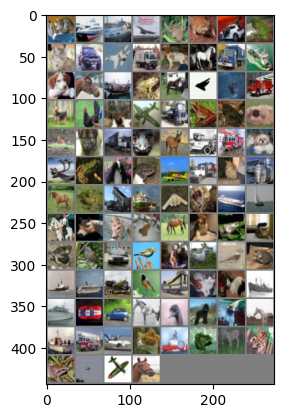

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   car   ship  ship 


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images and the ground truth
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


# Load the network from disk and run it on a single batch of the test images.
# net = Net()
# net.load_state_dict(torch.load(PATH))
outputs = net(images.to(device))

# Output the predicted labels
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
# Get the statistical prediction results for the whole test set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [ ]:
# Get the statistical prediction results for each category individually for the whole test set
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions.to('cpu')):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')



Accuracy for class: plane is 59.5 %
Accuracy for class: car   is 71.4 %
Accuracy for class: bird  is 27.2 %
Accuracy for class: cat   is 39.8 %
Accuracy for class: deer  is 56.5 %
Accuracy for class: dog   is 42.9 %
Accuracy for class: frog  is 86.0 %
Accuracy for class: horse is 62.9 %
Accuracy for class: ship  is 82.4 %
Accuracy for class: truck is 73.5 %


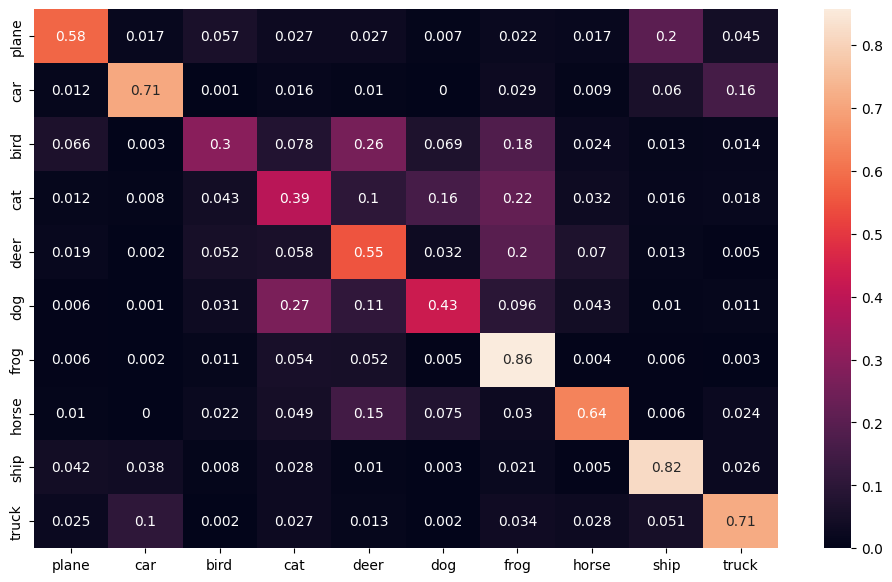

In [ ]:
# build a confusion matrix (based on tutorial from https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7)
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in testloader:

        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        y_pred.extend(predictions.to('cpu'))

        y_true.extend(labels)

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')